YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\grena\AppData\Local\Temp\ipykernel_21312\3762045991.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = yf.download(tickers, start='1980-01-01', end='2024-12-31', session=session)['Close'].resample('M').last()


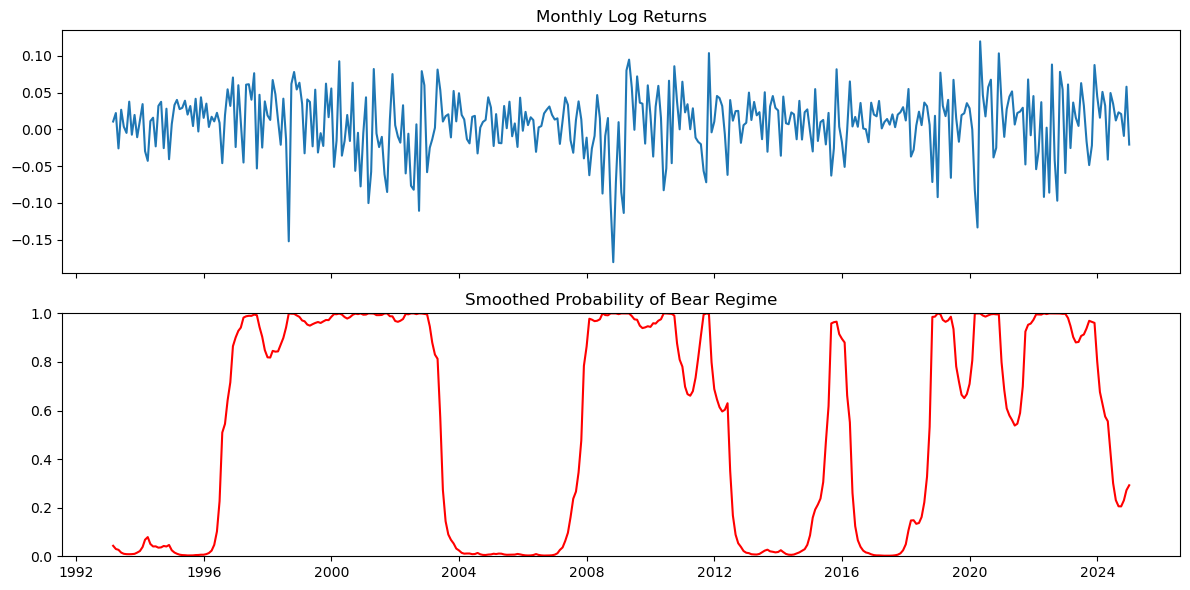

                        Markov Switching Model Results                        
Dep. Variable:                    SPY   No. Observations:                  383
Model:               MarkovRegression   Log Likelihood                 696.942
Date:                Fri, 16 May 2025   AIC                          -1381.885
Time:                        21:28:11   BIC                          -1358.196
Sample:                    02-28-1993   HQIC                         -1372.488
                         - 12-31-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.002      6.510      0.000       0.009       0.017
sigma2         0.0006   7.97e-05      7.015      0.0

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from curl_cffi import requests
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# --- Utility Functions ---
def expected_utility(alpha, gamma, rf, er_excess, sigma, skew, kurt):
    base = 1 + rf + alpha * er_excess
    if base <= 0:
        return -np.inf
    term1 = (base ** (1 - gamma)) / (1 - gamma)
    correction2 = -(gamma / 2) * (sigma ** 2) * (alpha ** 2) * base ** (-gamma - 1)
    correction3 = (gamma * (1 + gamma) / 6) * (sigma ** 3) * (alpha ** 3) * skew * base ** (-gamma - 2)
    correction4 = -(gamma * (1 + gamma) * (2 + gamma) / 24) * (sigma ** 4) * (alpha ** 4) * kurt * base ** (-gamma - 3)
    return term1 + correction2 + correction3 + correction4

def crra_objective(gamma, rf, er_excess, sigma, skew, kurt, alpha):
    return -expected_utility(alpha, gamma, rf, er_excess, sigma, skew, kurt)

def estimate_crra(rf, sigma, er_excess, skew, kurt, alpha=1.0):
    result = minimize_scalar(
        crra_objective,
        method='brent',
        bracket=(2, 7),
        args=(rf, er_excess, sigma, skew, kurt, alpha)
    )
    return result.x if result.success else np.nan

# --- Step 1: Download Data ---
session = requests.Session(impersonate="chrome")
tickers = ['SPY']
data = yf.download(tickers, start='1980-01-01', end='2024-12-31', session=session)['Close'].resample('M').last()

# --- Step 2: Monthly Log Returns ---
log_returns = pd.concat([
    np.log(data[ticker] / data[ticker].shift(1)).rename(ticker)
    for ticker in tickers
], axis=1)

spy_returns = log_returns['SPY'].dropna()
 
# --- Step 3: Fit Markov Switching Model ---
model = MarkovRegression(spy_returns, k_regimes=2, trend='c', switching_variance=True)
result = model.fit()

# --- Step 4: Extract Regime Probs and Parameters ---
smoothed_probs = result.smoothed_marginal_probabilities
pi_bear = smoothed_probs[1].mean()
pi_bull = 1 - pi_bear

params = result.params
mu_0 = params['const[0]']
mu_1 = params['const[1]']
sigma_0 = np.sqrt(params['sigma2[0]'])
sigma_1 = np.sqrt(params['sigma2[1]'])

# --- Step 5: Weighted Moments ---
mu_w = pi_bull * mu_0 + pi_bear * mu_1
var_w = pi_bull * (sigma_0**2 + mu_0**2) + pi_bear * (sigma_1**2 + mu_1**2) - mu_w**2
sigma_w = np.sqrt(var_w)

# --- Step 6: Estimate CRRA Gamma ---
rf = 0.00319  # Monthly risk-free rate (~3,9% annually)
skew_full = spy_returns.skew()
kurt_full = spy_returns.kurt() + 3
gamma_empirical_full = estimate_crra(rf, sigma_w, mu_w - rf, skew_full, kurt_full)

# --- Step 7: Plot Results ---
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(spy_returns.index, spy_returns, label='SPY Log Returns')
ax[0].set_title('Monthly Log Returns')
ax[1].plot(smoothed_probs[1].index, smoothed_probs[1], label='P(Bear Regime)', color='red')
ax[1].set_title('Smoothed Probability of Bear Regime')
ax[1].set_ylim(0, 1)
plt.tight_layout()
plt.show()

# --- Step 8: Output ---
print(result.summary())
print(f"\nEstimated CRRA gamma (weighted using empirical regime probabilities): {gamma_empirical_full:.2f}")

In [2]:
from scipy.stats import jarque_bera

# --- 3th and 4rd Moment Summary ---
print(f"Skewness: {skew_full:.4f}")
print(f"Kurtosis: {kurt_full:.4f}")

# --- Step 8: Jarque-Bera Test ---
jb_stat, jb_pvalue = jarque_bera(spy_returns)
print(f"Jarque-Bera test statistic: {jb_stat:.2f}")
print(f"Jarque-Bera p-value: {jb_pvalue:.4f}")


Skewness: -0.7545
Kurtosis: 4.3731
Jarque-Bera test statistic: 64.70
Jarque-Bera p-value: 0.0000


In [ ]:
# --- Compute Sharpe Ratios in Each Regime ---
sharpe_0 = (mu_0 - rf) / sigma_0
sharpe_1 = (mu_1 - rf) / sigma_1

sharpe_0_annual = sharpe_0 * np.sqrt(12)
sharpe_1_annual = sharpe_1 * np.sqrt(12)
print(f"\nAnnualized Sharpe Ratio (Regime 0): {sharpe_0_annual:.4f}")
print(f"Annualized Sharpe Ratio (Regime 1): {sharpe_1_annual:.4f}")



Annualized Sharpe Ratio (Regime 0): 1.4669
Annualized Sharpe Ratio (Regime 1): 0.0529


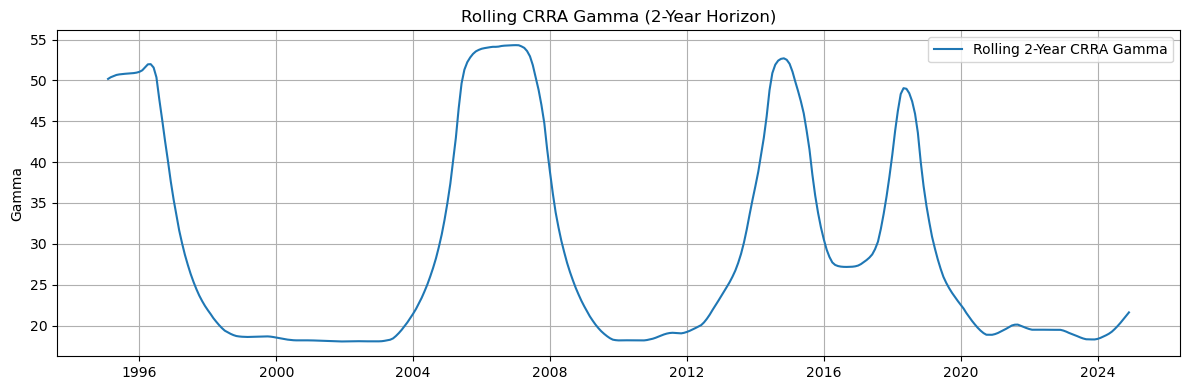

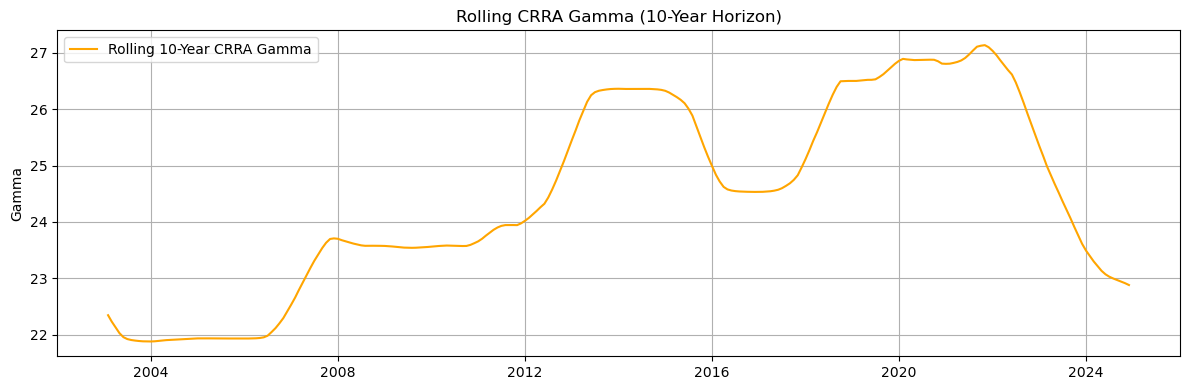

In [12]:
# --- Rolling CRRA gamma estimation function ---
def compute_rolling_gamma(spy_returns, smoothed_probs, mu_0, mu_1, sigma_0, sigma_1, rf, window_years, use_rolling_higher_moments=True):
    window_months = window_years * 12
    gammas, dates = [], []

    sigma2_0, sigma2_1 = sigma_0**2, sigma_1**2
    skew_full = spy_returns.skew()
    kurt_full = spy_returns.kurt() + 3

    for end_idx in range(window_months, len(spy_returns)):
        idx_range = spy_returns.index[end_idx - window_months:end_idx]
        probs_window = smoothed_probs.loc[idx_range]
        returns_window = spy_returns.loc[idx_range]

        pi_bear = probs_window[1].mean()
        pi_bull = 1 - pi_bear

        mu = pi_bull * mu_0 + pi_bear * mu_1
        var = pi_bull * (sigma2_0 + mu_0**2) + pi_bear * (sigma2_1 + mu_1**2) - mu**2
        sigma = np.sqrt(var)
        er_excess = mu - rf

        if use_rolling_higher_moments:
            skew = returns_window.skew()
            kurt = returns_window.kurt() + 3
        else:
            skew = skew_full
            kurt = kurt_full

        gamma = estimate_crra(rf, sigma, er_excess, skew, kurt)
        gammas.append(gamma)
        dates.append(idx_range[-1])

    return pd.Series(data=gammas, index=dates)

# --- Compute both --- (change last argument to False to fix skew/kurt)
gamma_2y = compute_rolling_gamma(spy_returns, smoothed_probs, mu_0, mu_1, sigma_0, sigma_1, rf, window_years=2, use_rolling_higher_moments=False)
gamma_10y = compute_rolling_gamma(spy_returns, smoothed_probs, mu_0, mu_1, sigma_0, sigma_1, rf, window_years=10, use_rolling_higher_moments=False)

# --- Plot 2-year ---
plt.figure(figsize=(12, 4))
plt.plot(gamma_2y, label='Rolling 2-Year CRRA Gamma')
plt.title('Rolling CRRA Gamma (2-Year Horizon)')
plt.ylabel('Gamma')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 10-year ---
plt.figure(figsize=(12, 4))
plt.plot(gamma_10y, label='Rolling 10-Year CRRA Gamma', color='orange')
plt.title('Rolling CRRA Gamma (10-Year Horizon)')
plt.ylabel('Gamma')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
